In [2]:
import sys

Mounted at /content/gdrive


In [29]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    # ! rm -r LastFM/
    # ! git clone https://github.com/TimofeevAlex/LastFM.git
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

Running on CoLab


In [4]:
import os
import sys
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import clear_output

from train_test import train_test_split
from models import create_ncf_model
from ncf_helpers import create_train_step, create_test_step, create_inference, get_ratings
from metrics import compute_metrics

%load_ext autoreload
%autoreload 2

seed=0
np.random.seed(seed)

It is impossible to merge datasets because of their sizes

In [5]:
train = pd.read_csv('lastfm-dataset-360K/train.csv')
valid = pd.read_csv('lastfm-dataset-360K/valid.csv')
test = pd.read_csv('lastfm-dataset-360K/test.csv')
lastfm_360_behav = pd.read_csv('lastfm-dataset-360K/behav-360k-processed.csv')
lastfm_360_demo = pd.read_csv('lastfm-dataset-360K/demo-360k-processed.csv')
lastfm_360_demo = lastfm_360_demo.set_index('user_email').astype(bool)
test_users = np.load('lastfm-dataset-360K/test_users.npy')

In [6]:
train_plays_max = train['log_plays'].max()
train['log_plays'] = train['log_plays'] / train_plays_max
valid['log_plays'] = valid['log_plays'] / train_plays_max
test['log_plays'] = test['log_plays'] / train_plays_max

In [7]:
artists = lastfm_360_behav['artist_id'].unique()
users = lastfm_360_demo.index.unique()

In [8]:
num_artists = artists.shape[0] 
num_users = users.max()
num_user_features = lastfm_360_demo.shape[1] 
num_factors = 16 
batch_size = 2 ** 16
k=10

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train)
train_dataset = train_dataset.batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.batch(batch_size)

In [11]:
model = create_ncf_model(num_factors, num_user_features, num_artists, num_users)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)#SGD(learning_rate=0.001, momentum=0.9)#
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.5)#smoothing #sample weight as well

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False, dpi=300)
plt.savefig('nlf_model_vertical.png')

<Figure size 432x288 with 0 Axes>

In [12]:
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

In [13]:
train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

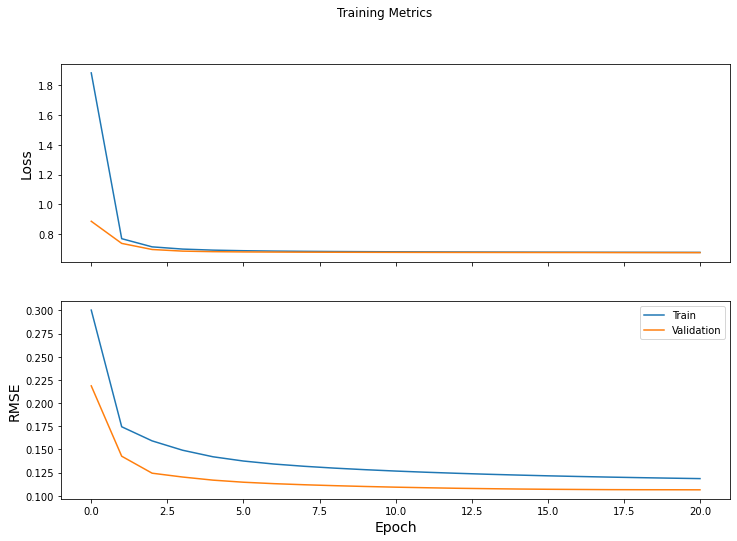

In [ ]:
num_epochs = 21
log_frequency = 1

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())
try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)
    
for epoch in range(num_epochs):
    epoch_loss_avg.reset_states()
    epoch_rmse.reset_states()
    for batch in train_dataset:
        user_id = batch[:, 0]
        user_feats = lastfm_360_demo.loc[user_id]
        artist_id = batch[:, 1]
        y = batch[:, 2]
        loss_value = train_step([user_id, user_feats, artist_id], y) 

    train_loss_results.append(epoch_loss_avg.result().numpy())
    train_rmse_results.append(epoch_rmse.result().numpy())

    if epoch % log_frequency == 0:
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        test_loss_avg.reset_states()
        test_rmse.reset_states()
        for batch in valid_dataset:
            user_id = batch[:, 0]
            user_feats = lastfm_360_demo.loc[user_id]
            artist_id = batch[:, 1]
            y = batch[:, 2]
            loss_value = test_step([user_id, user_feats, artist_id], y)
        test_loss_results.append(test_loss_avg.result().numpy())
        test_rmse_results.append(test_rmse.result().numpy())


        # Plot metrics  
        clear_output(wait=True)
        fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
        fig.suptitle('Training Metrics')

        axes[0].set_ylabel("Loss", fontsize=14)
        axes[0].plot(train_loss_results, label='Train')
        axes[0].plot(np.arange(0, epoch+1, log_frequency), test_loss_results, label='Validation')

        axes[1].set_ylabel("RMSE", fontsize=14)
        axes[1].set_xlabel("Epoch", fontsize=14)
        axes[1].plot(train_rmse_results, label='Train')
        axes[1].plot(np.arange(0, epoch+1, log_frequency), test_rmse_results, label='Validation')
        plt.legend()
        plt.savefig('plots/metrics_'+ timenow +'.png')
        plt.show()
        #plot gradients

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


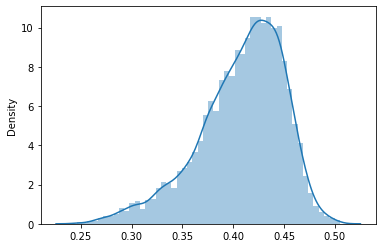

In [ ]:
inference = create_inference(model)
sns.distplot(inference([user_id, user_feats, artist_id]).numpy())

### Test

In [20]:
# model = tf.keras.models.load_model('saved_model/2021-05-16 20:01:08.830391/model_20')

In [21]:
inference = create_inference(model)

In [22]:
test_loss_avg.reset_states()
test_rmse.reset_states()
logits = np.array([])
for batch in test_dataset:
    user_id = batch[:, 0]
    user_feats = lastfm_360_demo.loc[user_id]
    artist_id = batch[:, 1]
    y = batch[:, 2]
    loss_value = test_step([user_id, user_feats, artist_id], y)
    logits = np.append(logits, inference([user_id, user_feats, artist_id]).numpy())
print('Test  MSE:', test_loss_avg.result().numpy())
print('Test RMSE:', test_rmse.result().numpy())

Test  MSE: 6.4821205
Test RMSE: 0.370117


In [26]:
seen_artists = train.append(valid).drop(columns='log_plays')
seen_artists = seen_artists[seen_artists['user_email'].isin(test_users)]
pred_ratings = get_ratings(inference, seen_artists, lastfm_360_demo, artists)

In [28]:
_, _, _, _, _  = compute_metrics(test, test_users, pred_ratings, k)

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.0
Recall    @ 10: 0.0
Ndcg @ 10: 0.0
Hit rate: 0.0
Arhr: 0.0
